# Árboles de decisión - Clasificación

## Importación de librerías

In [14]:
#Stack básico de análisis de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay )

## Carga del dataset

In [6]:
#CARGA DEL DATASET
def load_titanic():
    try:
        import seaborn as sns
        df = sns.load_dataset('titanic')
        source = "seaborn"
    except Exception:
        df = pd.read_csv("Titanic-Dataset.csv")
        source = "csv_local"
    return df, source

df_raw, source = load_titanic()
print(f"Fuente de datos: {source}")
df_raw.head()

Fuente de datos: seaborn


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Preparación de columnas

In [7]:
df = df_raw.copy()

target = 'survived'

candidate = [c for c in ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'embark_town', 'alone'] if c in df.columns]

data = df[candidate + [target]].copy()
data.head()

,pclass,sex,age,sibsp,parch,fare,embarked,embark_town,alone,survived
0,3,male,22.0,1,0,7.2500,S,Southampton,False,0
1,1,female,38.0,1,0,71.2833,C,Cherbourg,False,1
2,3,female,26.0,0,0,7.9250,S,Southampton,True,1
3,1,female,35.0,1,0,53.1000,S,Southampton,False,1
4,3,male,35.0,0,0,8.0500,S,Southampton,True,0


## Feature engineering 

In [8]:
if all(c in data.columns for c in ['sibsp','parch']):
    data['family_size'] = data['sibsp'].fillna(0) + data['parch'].fillna(0) + 1

# Discretización de edad (categoría)
if 'age' in data.columns:
    bins = [-np.inf, 12, 18, 35, 55, np.inf]
    labels = ['child','teen','young_adult','adult','senior']
    data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

# Interacción pclass x sex
if all(c in data.columns for c in ['pclass','sex']):
    data['pclass_sex'] = data['pclass'].astype(str) + "_" + data['sex'].astype(str)

data.head()

,pclass,sex,age,sibsp,parch,fare,embarked,embark_town,alone,survived,family_size,age_group,pclass_sex
0,3,male,22.0,1,0,7.2500,S,Southampton,False,0,2,young_adult,3_male
1,1,female,38.0,1,0,71.2833,C,Cherbourg,False,1,2,adult,1_female
2,3,female,26.0,0,0,7.9250,S,Southampton,True,1,1,young_adult,3_female
3,1,female,35.0,1,0,53.1000,S,Southampton,False,1,2,young_adult,1_female
4,3,male,35.0,0,0,8.0500,S,Southampton,True,0,1,young_adult,3_male


In [9]:
numeric_features = ['age', 'fare', 'family_size', 'sibsp', 'parch']
categorical_features = ['pclass', 'sex', 'embarked', 'alone', 'age_group', 'pclass_sex']

X = data[numeric_features + categorical_features]
y = data['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dimensiones:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Dimensiones: (712, 11) (179, 11) (712,) (179,)


## Pipeline preprocesamiento

In [10]:
# Nota: Los árboles de decisión no requieren escalado de características.
# Sin embargo, es importante manejar los valores faltantes y las variables categóricas.
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_features),    
    ("cat", categorical_pipeline, categorical_features) 
])

In [11]:
# Función util para nombre tras el OneHotEncoder
def get_ohe_feature_names(prep: ColumnTransformer, categorical_features):
    num_names = prep.transformers_[0][2] if len (prep.transformers_[0]) > 0 else []
    cat_trans =  prep.named_transformers_['cat']
    ohe = cat_trans.named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    return np.concatenate([num_names, cat_names])

## Modelo de árbol inicial

In [12]:
base_tree = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion='gini'))
])

base_tree.fit(X_train, y_train)
pred = base_tree.predict(X_test)
prob = base_tree.predict_proba(X_test)[:, 1]

=== DecisionTree (baseline) ===
Accuracy: 0.799 | Precision: 0.754 | Recall: 0.710 | F1: 0.731 | AUC: 0.776

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.82      0.85      0.84       110
          Sí       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



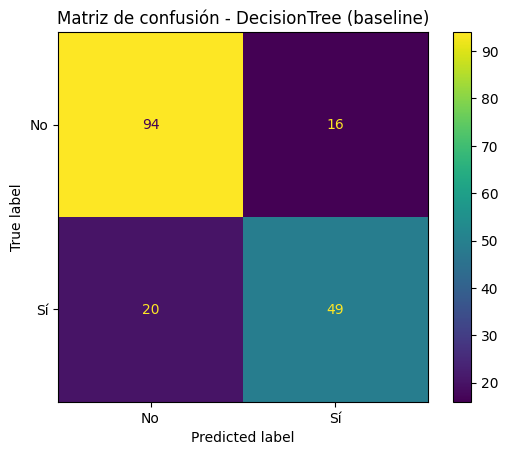

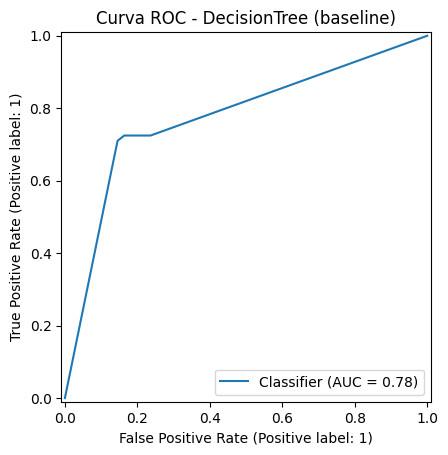

In [13]:
# Función para el reporte de métricas 
def report_metrics(yte, pred, proba, title="Modelo"):
    acc = accuracy_score(yte, pred)
    prec = precision_score(yte, pred)
    rec = recall_score(yte, pred)
    f1 = f1_score(yte, pred)
    auc = roc_auc_score(yte, proba)
    print(f"=== {title} ===")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    print("\nReporte de clasificación:")
    print(classification_report(yte, pred, target_names=["No","Sí"]))

    ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=["No","Sí"])
    plt.title(f"Matriz de confusión - {title}")
    plt.show()

    RocCurveDisplay.from_predictions(yte, proba)
    plt.title(f"Curva ROC - {title}")
    plt.show()

report_metrics(y_test, pred, prob, title="DecisionTree (baseline)")

## Visualización del Árbol 

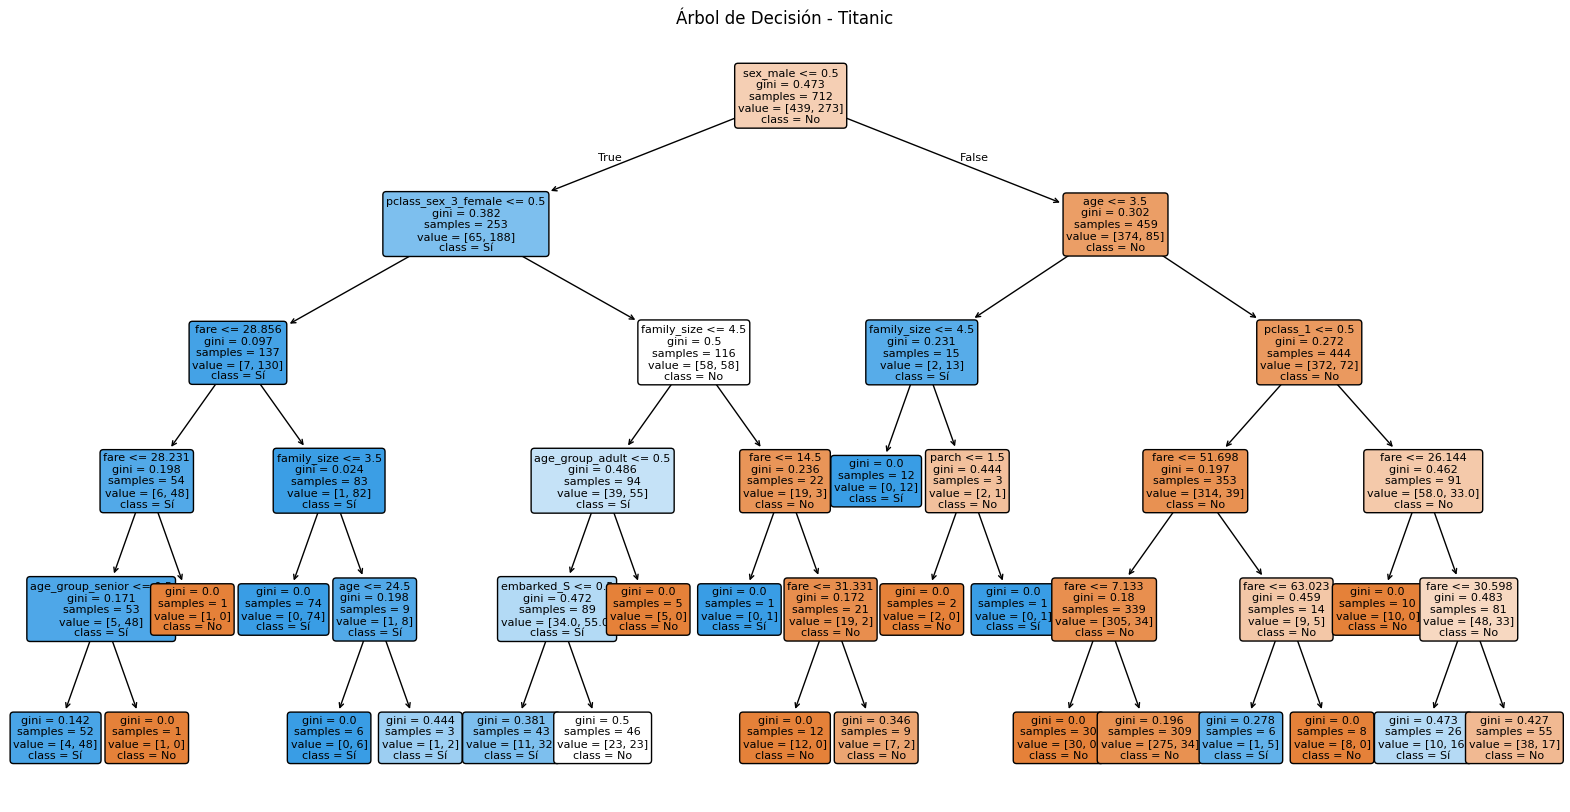

In [16]:
viz_tree =  Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        criterion='gini'))
])

viz_tree.fit(X_train, y_train)

prep_fit = viz_tree.named_steps['preprocessor'].fit(X_train)
feature_names = get_ohe_feature_names(prep_fit, categorical_features)
tree_clf = viz_tree.named_steps['classifier']

plt.figure(figsize=(20,10))
plot_tree(tree_clf, feature_names=feature_names, class_names=["No","Sí"], filled=True, rounded=True, fontsize=8)
plt.title("Árbol de Decisión - Titanic")
plt.show()

## Importancias de la caracteristicas

Top 15 características por importancia:


sex_male                 0.315047
fare                     0.237828
age                      0.192316
pclass_sex_3_female      0.078556
family_size              0.044007
pclass_sex_1_male        0.028549
sibsp                    0.017443
parch                    0.014973
embarked_S               0.013433
age_group_senior         0.011817
age_group_adult          0.011220
age_group_child          0.009688
age_group_young_adult    0.008330
embarked_Q               0.005430
age_group_teen           0.004137
dtype: float64

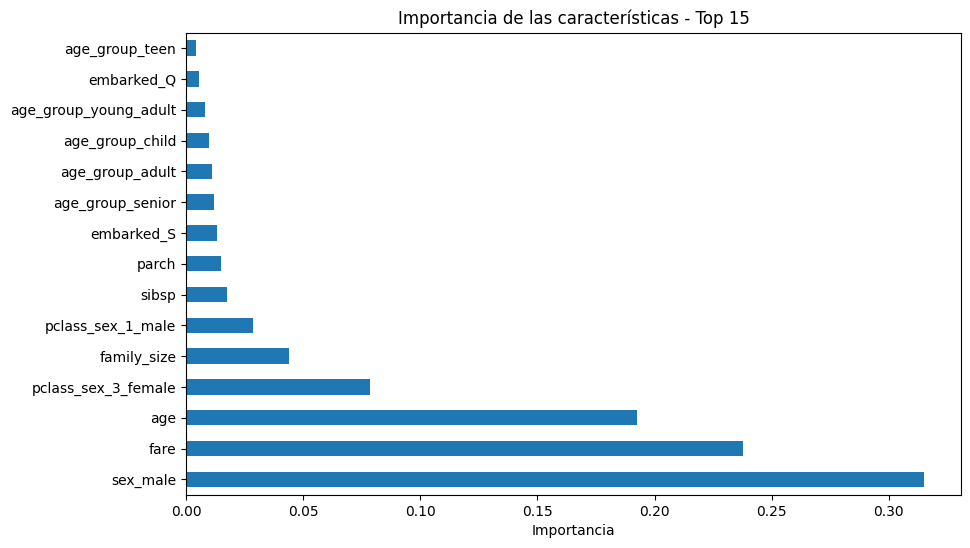

In [17]:
# Ajusto el pipeline

base_tree.fit(X_train, y_train)
prep_fit = base_tree.named_steps['preprocessor'].fit(X_train)
feature_names = get_ohe_feature_names(prep_fit, categorical_features)
tree_clf = base_tree.named_steps['classifier']

importeces = pd.Series(tree_clf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 15 características por importancia:")
display(importeces.head(15))

plt.figure(figsize=(10,6))
importeces.head(15).plot(kind='barh')
plt.title("Importancia de las características - Top 15")
plt.xlabel("Importancia")
plt.show()

## Búsqueda de los mejores hiperparámetros

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Mejores hiperparámetros: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Mejor score (F1): 0.765943732972403
=== DecisionTree (tuned) ===
Accuracy: 0.799 | Precision: 0.720 | Recall: 0.783 | F1: 0.750 | AUC: 0.807

Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.86      0.81      0.83       110
          Sí       0.72      0.78      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.80      0.80       179



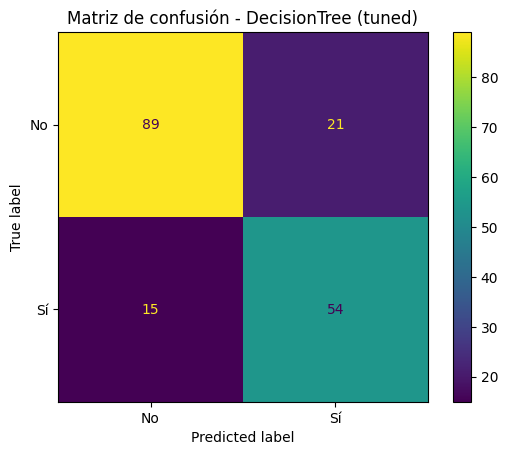

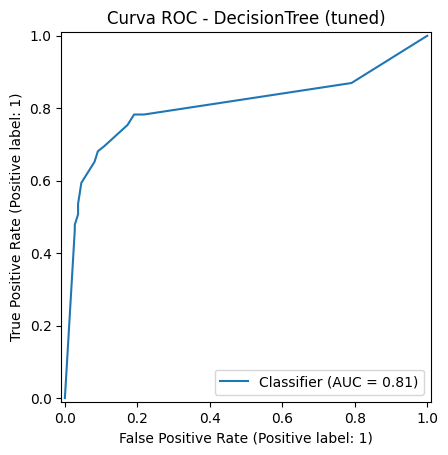

In [18]:
grip_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(grip_pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

gs.fit(X_train, y_train)
print("Mejores hiperparámetros:", gs.best_params_)
print("Mejor score (F1):", gs.best_score_)

best_tree = gs.best_estimator_
pred_best = best_tree.predict(X_test)
prob_best = best_tree.predict_proba(X_test)[:, 1]

report_metrics(y_test, pred_best, prob_best, title="DecisionTree (tuned)")